# La parte intermedia del modelado secuencial NLP
Ahora se realizara una secuencia de predicción. Aquí entra en juego un a tarea común en nlp, e la que permite predecir la siguiente palabra dado a una secuencia de palabras. part-of-sppech-taggin, predice la parte gramtica del discurso  para cada palabra, a esto se le llama named entity recognition o NER. En esta, decimos que cada palabra peude ser etiquetada como Presona, lugar, Producto u Organización. 
Este tipo tareas, puede entrar completamente un RNN, sin embargo, presentan un problema los modelos fundacionales de Ellman, y por lo que se utiliza otro componente adicional

## Los modelos de LSTM Y GRU 
Estos modelos vinieron a solventar la problemática del gradiente de desvanecimiento en el RNN
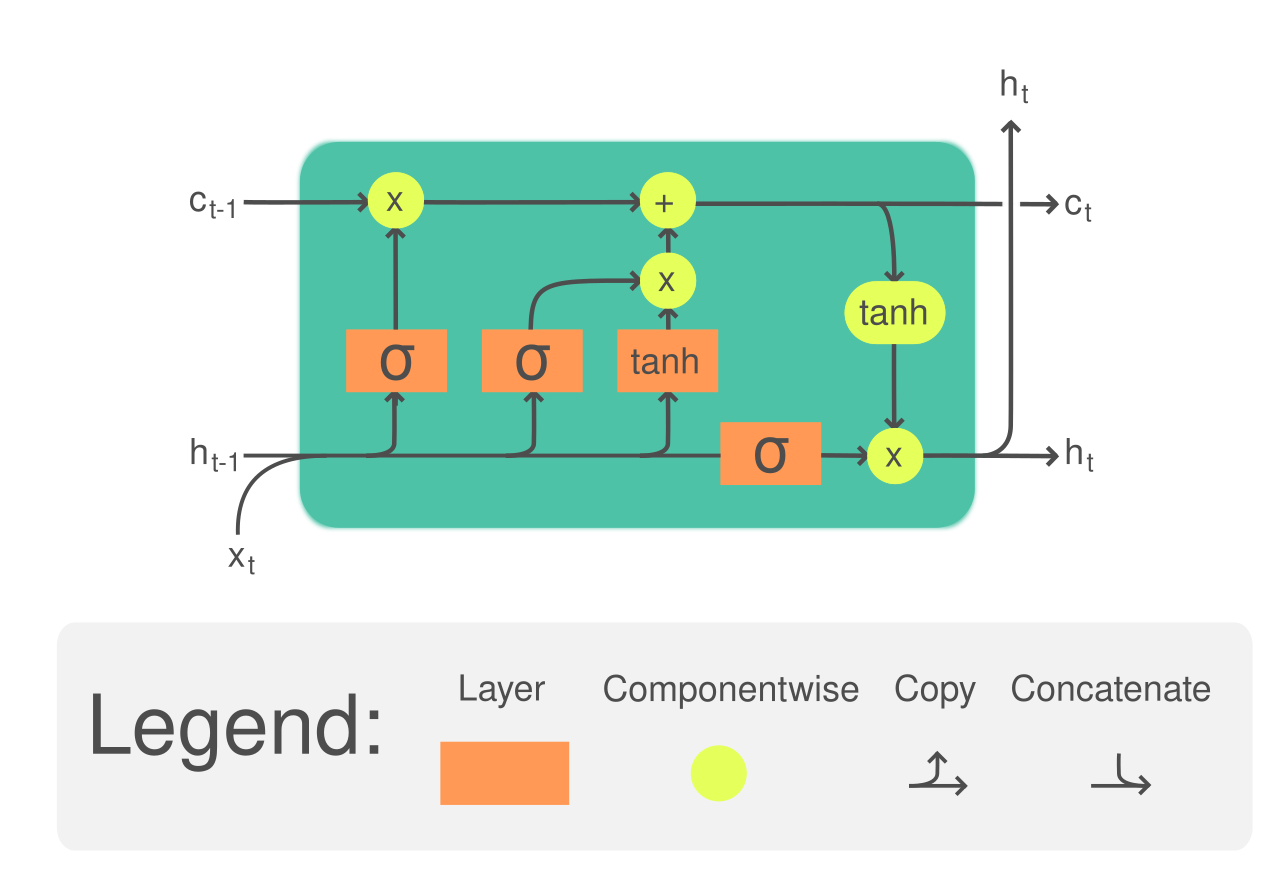

Un LSTM es una red neuronal recurrente que mantiene dos estados:
- Estado oculto: $ h_t $
- Estado de memoria (celda): $ c_t $

Estos estados se actualizan usando compuertas que controlan el flujo de información.

---

## Variables

- $ x_t $: entrada en el tiempo $ t $
- $ h_{t-1} $: estado oculto previo
- $ c_{t-1} $: estado de memoria previo
- $ h_t $: nuevo estado oculto
- $ c_t $: nuevo estado de memoria
- $ \sigma(\cdot) $: función sigmoide
- $ \tanh(\cdot) $: tangente hiperbólica
- $ \odot $: multiplicación elemento a elemento

---

## 1. Forget Gate (Compuerta de olvido)

Decide qué información del estado de memoria previo se conserva.

$$
f_t = \sigma\left(W_f \cdot [h_{t-1}, x_t] + b_f\right)
$$

---

## 2. Input Gate (Compuerta de entrada)

Decide qué información nueva se añade al estado de memoria.

### 2.1 Activación de entrada
$$
i_t = \sigma\left(W_i \cdot [h_{t-1}, x_t] + b_i\right)
$$

### 2.2 Estado candidato
$$
\tilde{c}_t = \tanh\left(W_c \cdot [h_{t-1}, x_t] + b_c\right)
$$

---

## 3. Actualización del estado de memoria

$$
c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t
$$

---

## 4. Output Gate (Compuerta de salida)

Decide qué parte del estado de memoria se expone como salida.

### 4.1 Activación de salida
$$
o_t = \sigma\left(W_o \cdot [h_{t-1}, x_t] + b_o\right)
$$

### 4.2 Estado oculto
$$
h_t = o_t \odot \tanh(c_t)
$$

---

## Resumen de ecuaciones

$$
\begin{aligned}
f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i) \\
\tilde{c}_t &= \tanh(W_c [h_{t-1}, x_t] + b_c) \\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o) \\
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$$

---
Enlace para ver más información
http://colah.github.io/posts/2015-08-Understanding-LSTMs/


In [1]:

from torch.utils.data import Dataset
import pandas as pd
class SurnameDataset(Dataset):
    # Se hereda la clase Dataset
    def __init__(self,surname_df,vectorizer):
        """
        Args:
            review_df(pandas.DataFrame): El conjunto de datos
            vectorizer(ReviewVectorizer): vectorizer instacinado desde el conjunto de datos
        """
        self.surname_df = surname_df
        
        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2
        self._vectorizer = vectorizer
        self.train_df= self.surname_df[self.surname_df.split=="train"]
        self.train_size=len(self.train_df)

        self.val_df= self.surname_df[self.surname_df.split=="val"]
        self.val_size=len(self.val_df)

        self.test_df= self.surname_df[self.surname_df.split=="test"]
        self.test_size=len(self.test_df)

        self._lookup_dic={'train':(self.train_df,self.train_size),
                         'val':(self.val_df,self.val_size),
                         'test':(self.test_df,self.test_size),
                         }
        self.set_split("train")
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
    @classmethod
    def load_dataset_and_make_vectorizer(cls,review_cls):
        """
        carga el dataset y hacer un nuevo vectorizador desde cero
        args:
                surname_cvs(str): ubicacion del dataset
        Returns:
            una instancia de ReviewDataset
        """
        surname_df= pd.read_csv(review_cls)
        return cls(surname_df,SurnameVectorizer.from_dataframe(surname_df))
    def get_vectorizer(self):
        """retorna el vectorizador"""
        return self._vectorizer
    def set_split(self,split="train"):
        """
        Selecciona la division en el conjunto de datos usando una columna en el dataframe
        args:
        split(str):  uno de "train","val","test"
        """
        self._target_split=split
        self._target_df,self._target_size=self._lookup_dic[split]
    def __len__(self):
        return self._target_size
    def __getitem__(self,index):
        """
        El punto primario de entrada como metodo para PyTorch en lso conjuntos de datos
        Args:
        index(int): Es el inice del dato
        Returns:
            Diccionario de las caracterizitcads de los puntos de datos y labels
        """
        row=self._target_df.iloc[index]
        from_vector, to_vector=self._vectorizer.vectorize(row.surname,self._max_seq_length)
        nationality_index=self._vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {'x_data':from_vector,
                'y_target':to_vector,
               'class_index':nationality_index}
    def get_num_batches(self,batch_size):
        """
        Dado un tamaño de batch , retorna el numero de batches del conjunto de datos
        Args: 
            batch_size(int)
        Returns:
            Numero de batches en el conjuntos
        """
        return len(self)//batch_size

In [2]:
import pandas as pd
import torch
import numpy as np
class Vocabulary(object):
    """ Clase a procesar texto y extrar el vocabulario para mappear"""
    def __init__(self,token_to_idx=None,add_unk=True,unk_token="<UNK>"):
        """Args:
            token_to_idx (dict): un mapa pre existen de toknes a indices
            add_unk(bool): un bandera que indica si se añade el token UNK de desconocido
            unk_token(str): el token UNK se añade a el vocabulario
            """
        if token_to_idx is None:
            token_to_idx={}
        self._token_to_idx=token_to_idx
        self._idx_to_token={idx: token
                           for token,idx in self._token_to_idx.items()}
        self._add_unk=add_unk
        self._unk_token=unk_token
        self.unk_index=-1
        if add_unk:
            self.unk_index=self.add_token(unk_token)
    def to_serializable(self):
        """ Retorna un diccionario que puede ser serializado """
        return {"token_to_idx":self._token_to_idx,
               "add_unk":self._add_unk,
               "unk_token":self._unk_token}
    @classmethod
    def from_serializable(cls,contents):
        """instancia el bocabulario desde un diccionario serializado"""
        return cls(**contents)
    def add_token(self,token):
        """
        Actualiza los mapeos de diccionarrios basados en los tokens
        Args:
            token (str): el item a añadir en el vocabulario
        Returns:
            index(int) : el entero correspondiente al token
        """
        if token in self._token_to_idx:
            index=self._token_to_idx[token]
        else:
            index=len(self._token_to_idx)
            self._token_to_idx[token]=index
            self._idx_to_token[index]=token
        return index
    def lookup_token(self,token):
        """ Obtiene el indice asociado con el tokenn de UNK token si el token no está presente,
        Args:
            token (str): el token a observar
        returns :
            index (int) el indices correspondiente al token
        Notes:
               `unk_index` necesita ser entero positivo (habiendo sido añadido al vocabulario) para la funcionalidad desconocidad
               """
        if self._add_unk:
            return self._token_to_idx.get(token,self.unk_index)
        else:
            return self._token_to_idx[token]
    def lookup_index(self,index):
        """ Obtiene el token asociado al indice
        Args:
            index (int): el indice a observar
        returns :
            token (str) el token correspondiendte al indices
        Raises:
            KeyError: si el indice no está en el vocabulario
        """
        if index not in self._idx_to_token:
            raise KeyError("El indice (%d)no está en el vocabulario" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):#Refleja la longitudad del vocabulario
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [5]:
from collections import Counter
import string
class SurnameVectorizer(object):
    """ La clase vectorizer de las cuales, suss coordenadas son las del vocabulario"""
    def __init__(self,char_vocab,nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab
    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized title (numpy.array)
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) 
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)
        
        if vector_length < 0:
            vector_length = len(indices)-1
        from_vector=np.zeros(vector_length,dtype=np.int64)
        from_indices= indices[:-1]
        from_vector[:len(from_indices)]=from_indices
        from_vector[len(from_indices):]=self.char_vocab.mask_index

        to_vector=np.empty(vector_length,dtype=np.int64)
        to_indices=indices[1:]
        to_vector[:len(to_indices)]=to_indices
        to_vector[len(to_indices):]=self.char_vocab.mask_index
        
        return from_vector,to_vector

    @classmethod
    def from_dataframe(cls, surname_df ):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            news_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the NewsVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab=Vocabulary()
        for index,row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)
        return cls(char_vocab,nationality_vocab)
    @classmethod 
    def from_serializable(cls, contents):
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nat_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])

        return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

    def to_serializable(self):
        return {'char_vocab': self.char_vocab.to_serializable(), 
                'nationality_vocab': self.nationality_vocab.to_serializable()}


# GRU
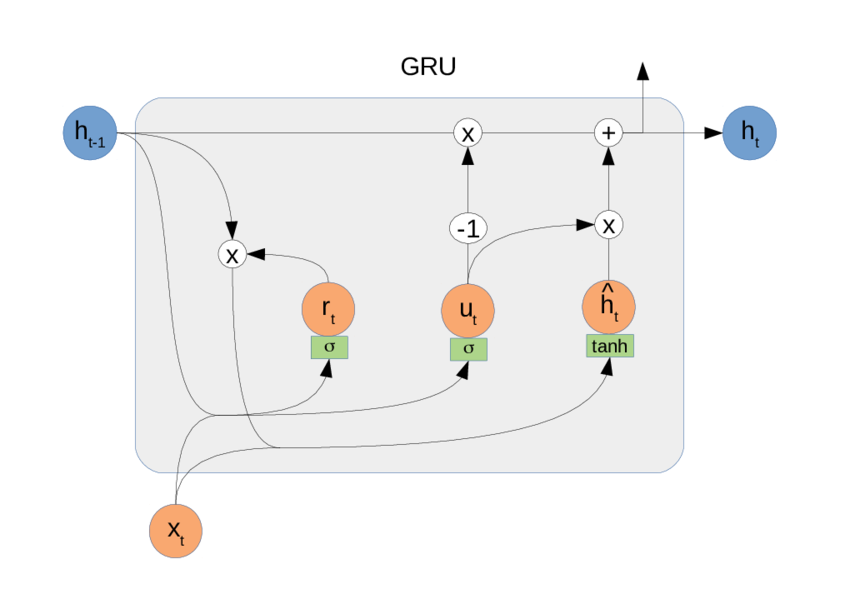

In [6]:
import torch.nn as nn
import torch.nn.functional as F
class SurnameGenerationModel(nn.Module):
    def __init__(self,char_embedding_size,char_vocab_size,rnn_hidden_size,
                 batch_first=True, padding_idx=0, dropoutp=0.5):
        """
        ARGS:
            char_embedding_size (int): El tamaño de los embeddings de caracteres
            char_vocab_size (int): El numbero de caracteres a embebebe
            rnn_hidden_size(iint): El tamaño del estaod oculto del RNN
            batch_first (bool): Informa si los tensores de entrada seran batch o serán secuqnias en la dimensión 0
            padding_idx (int): el indice para el borde del dtensor, vea el torch.nn.Embedding
            dropout_p (float): la probabilidad de que las activaziciones de 0 usen el metodo de dropout
        """
        super(SurnameGenerationModel,self).__init__()
        self.char_emb =nn.Embedding(num_embeddings=char_vocab_size,embedding_dim=char_embedding_size,padding_idx=padding_idx)
        self.rnn= nn.GRU(input_size=char_embedding_size,hidden_size=rnn_hidden_size,batch_first=batch_first)
        self.fc= nn.Linear(in_features=rnn_hidden_size,out_features=char_vocab_size)
        self._dropout_p=dropoutp
    def forward(self,x_in,apply_softmax=False):
        """el paso hacia adelante del modelo 
        x_in (torch.Tensor): un entrada de tipo tensor
        x_iin.shape debe ser batch,input_dim
        apply_fostmax (bool): una bandera par la activacion de softmax dfebe ser falas para el entrenamiento
        Retorna 
        el tensor resultante que debe ser (batch_dim,output_dim)
        """
        x_embedded=self.char_emb(x_in)
        y_out, _=self.rnn(x_embedded)
        batch_size,seq_size,feat_size= y_out.shape
        y_out=y_out.contiguous().view(batch_size*seq_size,feat_size)
        y_out=self.fc(F.dropout(y_out,p=self._dropout_p))
        if apply_softmax:
            y_out= F.softmax(y_out,dim=1)
        new_feat_size= y_out.shape[-1]
        y_out=y_out.view(batch_size,seq_size,new_feat_size)
        return y_out

## Mpodelo condicionando

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class SurnameGenerationModel_(nn.Module):
    def __init__(self,char_embedding_size,char_vocab_size,num_nationalities,rnn_hidden_size,
                 batch_first=True, padding_idx=0, dropoutp=0.5):
        """
        ARGS:
            char_embedding_size (int): El tamaño de los embeddings de caracteres
            char_vocab_size (int): El numbero de caracteres a embebebe
            rnn_hidden_size(iint): El tamaño del estaod oculto del RNN
            batch_first (bool): Informa si los tensores de entrada seran batch o serán secuqnias en la dimensión 0
            padding_idx (int): el indice para el borde del dtensor, vea el torch.nn.Embedding
            dropout_p (float): la probabilidad de que las activaziciones de 0 usen el metodo de dropout
        """
        super(SurnameGenerationModel,self).__init__()
        self.char_emb =nn.Embedding(num_embeddings=char_vocab_size,embedding_dim=char_embedding_size,padding_idx=padding_idx)
        self.rnn= nn.GRU(input_size=char_embedding_size,hidden_size=rnn_hidden_size,batch_first=batch_first)
        self.fc= nn.Linear(in_features=rnn_hidden_size,out_features=char_vocab_size)
        self._dropout_p=dropoutp
        self.nation_embedding=nn.Embedding(embedding_dim=rnn_hidden_size,num_embeddings=num_nationalities)
    def forward(self,x_in,nationality_index,apply_softmax=False):
        """el paso hacia adelante del modelo 
        x_in (torch.Tensor): un entrada de tipo tensor
        x_iin.shape debe ser batch,input_dim
        apply_fostmax (bool): una bandera par la activacion de softmax dfebe ser falas para el entrenamiento
        Retorna 
        el tensor resultante que debe ser (batch_dim,output_dim)
        """
        x_embedded=self.char_emb(x_in)
        nationality_embedded =self.nation_embedding(nationality_index).unsqueeze(0)
        y_out, _=self.rnn(x_embedded,nationality_embedded)
        batch_size,seq_size,feat_size= y_out.shape
        y_out=y_out.contiguous().view(batch_size*seq_size,feat_size)
        y_out=self.fc(F.dropout(y_out,p=self._dropout_p))
        if apply_softmax:
            y_out= F.softmax(y_out,dim=1)
        new_feat_size= y_out.shape[-1]
        y_out=y_out.view(batch_size,seq_size,new_feat_size)
        return y_out

# Recambios
En esta seccion, se modifica la manera en que la funcion de perdidad s e clacula, y auqe tenemos tenesores de 3 dimensiones, por lo que necesitamos solo modfiicar el tamñao para que pueda ser calcualdo

In [10]:
def normalize_sizes(y_pred,y_true):
    """
    normaliza los tsmaños de los tensores
    Args:
        y_pred: (torch.Tensor): la salida del model ia es un 3 dimeniones , la cambai a una forma de matriz
        y_true:  ls predicciones objetovo i una matriz se rehace apra ser vector
    """
    if len(y_pred.size())==3:
        y_pred= y_pred.contiguous().view(-1,y_pred.size(2))
    if len(y_true.size())==3:
        y_true = y_true.contiguous().view(-1)
    return y_pred,y_true
def sequence_loss(y_pred,y_true,mask_index):
    y_pred, y_true =normalize_sizes(y_pred,y_true)
    return F.cross_entropy(y_pred,y_true,ignore_index=mask_index)

In [12]:
from argparse import Namespace
args=Namespace(
    #Datos y direcciones
    cuda=True,
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_nlp",
    hidden_dim=100,
    num_channels=256,
    # Model hyper parameter
    char_embedding_size=32,
    rnn_hidden_size=32,
   
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=128,
    )

In [14]:
#El conjunto de datos instanciado
import torch.optim as optim
dataset=SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer= dataset.get_vectorizer()

classifier = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)
if not torch.cuda.is_available():
    args.cuda=False
args.device= torch.device("cuda" if args.cuda else "cpu")
classifier.to(args.device)


optimizer=optim.Adam(classifier.parameters(),lr=args.learning_rate)

# Utilidades

In [13]:
def make_train_state(args):
    return { "epoch_index":0,
             "train_loss": [],
             "train_acc":[],
             "val_loss":[],
             "val_acc":[],
             "test_loss":-1,
             "test_acc":-1}
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100
def generate_batches(dataset,batch_size,shuffle=True,
                     drop_last=True,device="cpu"):
    """Una funcion generation la que wrapea ek dataloader de pytorxh. SE asegurarar de que cada tesnor este en un unico dispositivo
    """
    dataloader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# Sampling
>Aquí es donde se hacen muestros con el modelo incondicionado

In [15]:
def sample_from_model(model,vectorizer,num_samples=1,sample_size=20,temperature=1.0):
    """Muestrea una secuencia de indices desde el modelo
    args:
        model(SurnameGenerationModel): el modelo entrenado
        vectorizer( Surnmamevectorize): el vectorizador correspondiente
        num_samples(int): el numerpo de muestras
        sample_size(int): la maxima longitudde muestras
        temperature (float): acnetua o faltneiza la distribucion  multinomil
        0.0< temperatura <1.0 la hara mas puntiaguda
        temperatura>! l hara mas uniforme
    retorna:
    indices (torch.Tensor): la matriz de indices
    shape = (numero de muestras, tamaño de muestra)
    """
    begin_seq_index= [vectorizer.char_vocab.begin_seq_index
                     for _ in range(num_samples)]
    begin_seq_index = torch.Tensor(begin_seq_index,dtype=torch.int64).unsqueeze(dim=1)
    indices= [begin_seq_index]
    h_t=None
    for time_step in range(sample_size):
        x_t = indices[time_step]
        x_emb_t = model.char_emb(x_t)
        rnn_out_t, h_t =model.rnn(x_emb_t,h_t)
        prediction_vector = model.fc(rnn_out_t.squeeze(dim=1))
        probability_vector= F.softmax(prediction_vector / temperature,dim=1)
        indices.append(torch.multinomial(probability_vector,num_samples=1))
    indices= torch.stack(indices).squeeze().permute(1,0)
    return indices
def decode_samples(sampled_indices,vectorizer):
    """Transforma los indices a una forma de string ed un apellido
    args:
    sampled_indices (torch.Tensor): los indices desde sample_:from_model
    vectoriszer( SrunameVectorizer): el vectorizador correspondiente
    """
    decoded_surnames=[]
    vocab=vectorizer.char_vocab
    for sample_index in range(sampled_indices.shape[0]):
        surname=""
        for time_step in range(sampeld_indices.shape[1]):
            sample_item =sampled_indices[sample_index,time_step].item()
            if sample_item == vocab.begin_seq_index:
                continue
            elif sample_item==vocab.end_seq_index:
                break
            else:
                surname +=vocab.lookup_index(sample_item)
        decoded_surnames.append(sample_item)
    return decoded_surnames

## Modelo condicionado

In [17]:
def sample_from_model(model,vectorizer,nationalities,sample_size=20,temperature=1.0):
    """Muestrea una secuencia de indices desde el modelo
    args:
        model(SurnameGenerationModel): el modelo entrenado
        vectorizer( Surnmamevectorize): el vectorizador correspondiente
        nationalities(list): una lista de enterores representando las nacionalidades
        sample_size(int): la maxima longitudde muestras
        temperature (float): acnetua o faltneiza la distribucion  multinomil
        0.0< temperatura <1.0 la hara mas puntiaguda
        temperatura>! l hara mas uniforme
    retorna:
    indices (torch.Tensor): la matriz de indices
    shape = (numero de muestras, tamaño de muestra)
    """
    num_samples= len(nationalities)
    begin_seq_index= [vectorizer.char_vocab.begin_seq_index
                     for _ in range(num_samples)]
    begin_seq_index = torch.Tensor(begin_seq_index,dtype=torch.int64).unsqueeze(dim=1)
    indices= [begin_seq_index]
    nationality_indices= torch.tensor(nationalities,dtype=torch.int64).unsqueeze(dim=0)
    h_t=model.nation_emb(nationality_indices)
    for time_step in range(sample_size):
        x_t = indices[time_step]
        x_emb_t = model.char_emb(x_t)
        rnn_out_t, h_t =model.rnn(x_emb_t,h_t)
        prediction_vector = model.fc(rnn_out_t.squeeze(dim=1))
        probability_vector= F.softmax(prediction_vector / temperature,dim=1)
        indices.append(torch.multinomial(probability_vector,num_samples=1))
    indices= torch.stack(indices).squeeze().permute(1,0)
    return indices
def decode_samples(sampled_indices,vectorizer):
    """Transforma los indices a una forma de string ed un apellido
    args:
    sampled_indices (torch.Tensor): los indices desde sample_:from_model
    vectoriszer( SrunameVectorizer): el vectorizador correspondiente
    """
    decoded_surnames=[]
    vocab=vectorizer.char_vocab
    for sample_index in range(sampled_indices.shape[0]):
        surname=""
        for time_step in range(sampeld_indices.shape[1]):
            sample_item =sampled_indices[sample_index,time_step].item()
            if sample_item == vocab.begin_seq_index:
                continue
            elif sample_item==vocab.end_seq_index:
                break
            else:
                surname +=vocab.lookup_index(sample_item)
        decoded_surnames.append(sample_item)
    return decoded_surnames

In [16]:
from torch.utils.data import DataLoader
train_state=make_train_state(args)
for epoch_index in range(args.num_epochs):
    train_state['epoch_index']=epoch_index
    # Itera sobre nuestro dataset
    #Configura: el generador de batch, la perdidad, el accuracy a 0 y el conjunto de entrenamiento a activo
    dataset.set_split("train")
    batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
    running_loss=0.0
    running_acc=0.0
    classifier.train()
    for batch_index,batch_dict in enumerate(batch_generator):
        
        # La rutina de entrenamiento se conforma de 5 pasos

        #paso 1, los gradientes en cero
        optimizer.zero_grad()
        #Paso . calcula la salida
        y_pred=classifier(batch_dict["x_data"])
        #paso 3, calcula la perdidad
        loss=loss_func(y_pred,batch_dict["y_data"])
        loss_batch=loss.to("cpu").item()
        running_loss+=(loss_batch-running_loss)/(batch_index+1)
        #paso 4, usa la perdidad para producir el gradiente
        loss.backward()
        #Paso 5, usa el otpimizar para que tomo el paso gradiente
        optimizer.step()

        ##Calcula el accuracy
        acc_batch=compute_accuracy(y_pred,batch_dict["y_data"])
        running_acc+=(acc_batch-running_acc)/(batch_index+1)
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)

    #Iterar sobre el dataset de validacion
    #Configura, el generator de batch, la perdiddad, el accuracy a 0 y modo eval
    dataset.set_split("val")
    batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
    running_loss=0.0
    running_acc=0.0
    classifier.eval()
    #Empieza la evaluacion
    for batch_index,batch_dict in enumerate(batch_generator):
        # Paso 1: calcula la salida
        y_pred=classifier(batch_dict["x_data"])
        # paso 2, calcula la salida
        loss = loss_func(y_pred,batch_dict['y_data'])
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss)/(batch_index+1)
        #paso 3, calcula el accuracy
        acc_batch= compute_accuracy(y_pred,batch_dict['y_data'])
        running_acc+=(acc_batch-running_acc)/(batch_index+1)
    train_state["val_loss"].append(running_loss)
    train_state["val_acc"].append(running_acc)

NameError: name 'loss_func' is not defined

# Por el momento
> Dejare esta sección a espera de entrenarse, sin embargo, estos trucos son relevantes a tomr en cuenta, ya que la programación de modelos seucqciales puede ser algo desafiante

## Cuando sea en lo posible, usa las variantes de puentes

> Las arquitecturas de puertas permiten simplificar el entrenamiento solucionando mucho de los problemas de la estabilidad numerica
## Cuando en lo posible, utiliz mejor GRU que LSTM
> GRU usa menos párametros a calcular y son menos operaciones y llegando a alcanzar ejecuciones con resultados muy similares
## Usa ADAM como optimizador
> Es de los optimizadores que convergne más rapido que otras alternativvas, y sobre todo en modelos secuenciales , si no convergen con Adam, es donde en verdad se debe de probar con otro optimizador
## La utilidad del Gradient clipping
> Es una forma de encontrar los valores numericos que va teniendo con tu optimizador
## Early stop
> Con modelos secuenciales es comun sobreajustarpor lo que si es recomendar parar de forma adecuada

Esta fue la idea principal de los modelos de secuencia, en el siguiente se toma en cuenta los modelos secuencia a secuencia